# Universal Perturbative SF-[2]$_{R12}$ Correction

In [1]:
import tequila as tq
import numpy
import psi4

In this tutorial, we present the integration of the (spin-free) universal F12 correction by [3], initially proposed in a
spin-orbital form in [2]. This perturbative correction takes as input only the 1- and 2-RDM (see [ReducedDensityMatrices-tutorial](https://github.com/aspuru-guzik-group/tequila/blob/master/tutorials/ReducedDensityMatrices.ipynb))
 of an arbitrary reference method. This correction aims to account for the basis-set
incompleteness due to the correlation cusp, and aims to fish in the same waters as methods based on the quantum
subspace expansion (QSE). Recently, a similar approach, yet as an a priori modification, has been carried out by
[5] and [6], incorporating the transcorrelated Hamiltonian as explicitly correlated method. The difference is here, that
the RDMs do not need to be resolved, but additional integrals need to be computed beforehand. Looking only at the additional cost on
classical computers, they both scale approximately $\mathcal{O}(N^6)$ in the particle number. An integration of [2]-R12
into VQE makes insofar sense, because often, the 1- and 2-RDM need to be measured for the evaluation of general observables,
and maybe one wants to leave the input-molecular integrals as is.

To run this tutorial, you need to install `Psi4` from [this repository](https://github.com/philipp-q/psi4/tree/ri_space) for the GBS-based calculations. Molecular integrals for the MRA-PNOs are provided.

## Procedure
The overall procedure goes as follows:
1. Compute a reference. Here, we pick VQE. 
1. Set up the correction. This broadly needs the 1- and 2-RDM, an additional CABS basis and a f12-exponent as input.
    - Compute the RDMs. 
        - Precompute the RDMs and hand over explicitly + code ex
        - Specify a quantum circuit and a set of (fixed) parameters
        - Specify a dictionary specifying instruction to compute the RDMs via CI in `Psi4` 
    - The CABS basis is necessary for a _resolution of the identity_ approximation, that is used to avoid higher-order molecular integrals, and serves as well as additional space beyond the reference, that the perturbative method exploits in order to account for the the incompleteness of the reference basis set.
    - The f12-exponent $\texttt{gamma}$ is used for the correlation factor $f_{12}=-\texttt{1/gamma}* \texttt{exp(-gamma*}r_{12}\texttt{)}$, which is required for certain, new appearing molecular integrals.
1. Add reference energy and correction to obtain final, corrected energy









In [2]:
# Here, we look at the diatomic Hydrogen molecule.

geomstring = "H 0.0 0.0 0.0\nH 0.0 0.0 {R:.5f}"
distances = [0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 2, 3.000, 4.00 ]

## Different choices of CABS basis

### Active space
Within the `active`-approximation, we use a certain basis set for the RI (resolution of the identity), and slice out
an orbital space for the reference calculation by an active space approximation. The remaining basis functions
serve as complementary CABS basis.

Hence, to compute the correction, we need to specify that we want to use `active`-integrals, whereas the reference computation
readily carries specification of the active space.

This strategy works well if one uses a chemically sensible active space and one wants to increase the accuracy. However, results are sensitive to the choice of the active space. Therefore, selecting a large basis set and using some arbitrary orbitals may not lead to accurate energies overall. 

In [3]:
# `Active` procedure for the F12 correction
basis_set = 'cc-pvdz' ##'data/f12correction/sto3g+ccpvdzf12optri'
energy_active = numpy.zeros(len(distances))
corr_active = numpy.zeros(len(distances))
active_orbitals = list(range(4))
# Compute PES of 'active'
for l,r in enumerate(distances):
    geometry = geomstring.format(R=r)
    # Set molecule
    mol = tq.Molecule(geometry=geometry, basis_set=basis_set, active_orbitals=active_orbitals)
    # Compute energy via UCCSD
    U = mol.make_uccsd_ansatz(trotter_steps=1)
    H = mol.make_hamiltonian().simplify()
    E = tq.ExpectationValue(H=H, U=U)
    result = tq.minimize(method='bfgs', objective=E, silent=True, initial_values=0.0)  # HF reference
    energy_active[l] = result.energy

    # Compute RDMs
    mol.compute_rdms(U=U, variables=result.angles)
    # Compute correction
    corr_active[l] = mol.perturbative_f12_correction(rdm1=mol.rdm1, rdm2=mol.rdm2, cabs_type='active', gamma=1.4,
                                                    **{"silent": True})
    
    
print(energy_active, corr_active, energy_active+corr_active)

Set up universal f12-correction using a HF-RI-basis, with an active space as OBS.
Computing with dim(OBS): 4, of which 4 active and dim(RI): 10.
Therefore effective OBS: 4 and effective CABS: 6
Set up universal f12-correction using a HF-RI-basis, with an active space as OBS.
Computing with dim(OBS): 4, of which 4 active and dim(RI): 10.
Therefore effective OBS: 4 and effective CABS: 6
Set up universal f12-correction using a HF-RI-basis, with an active space as OBS.
Computing with dim(OBS): 4, of which 4 active and dim(RI): 10.
Therefore effective OBS: 4 and effective CABS: 6
Set up universal f12-correction using a HF-RI-basis, with an active space as OBS.
Computing with dim(OBS): 4, of which 4 active and dim(RI): 10.
Therefore effective OBS: 4 and effective CABS: 6
Set up universal f12-correction using a HF-RI-basis, with an active space as OBS.
Computing with dim(OBS): 4, of which 4 active and dim(RI): 10.
Therefore effective OBS: 4 and effective CABS: 6
Set up universal f12-correctio

## CABS+
The CABS+ approach [1] build a complementary space, that is orthogonal to the reference basis, given a reference basis and CABS basis set.
Since it was found in [1], that it is important, that the RI space fully contains the reference, this is contrived
by the union of both bases. Note, that this is what we did in the `active` example above, yet without projecting out the reference space from the
RI space.

This approach requires additional information about the CABS basis.


In [4]:
# CABS+ procedure for the F12 correction
basis_set = '6-31g'
energy_cp = numpy.zeros(len(distances))
corr_cp = numpy.zeros(len(distances))
# Compute PES of 'cabs+'
for l,r in enumerate(distances):
    geometry = geomstring.format(R=r)
    # Set molecule
    mol = tq.Molecule(geometry=geometry, basis_set=basis_set, point_group='c1', threads=3)  # CABS+ works only for C1 symmetry

    # Compute RDMs
    mol.compute_rdms(psi4_method='detci', psi4_options={'detci__ex_level': 2}) # CISD is exact here
    energy_cp[l] = mol.logs['detci'].variables["CI TOTAL ENERGY"]
    # Compute correction
    corr_cp[l] = mol.perturbative_f12_correction(rdm1=mol.rdm1, rdm2=mol.rdm2, cabs_type='cabs+', gamma=1.4,
                                              cabs_options={'cabs_name': 'cc-pvdz-f12-optri'}, **{"silent": True})


Set up universal f12-correction using the CABS+ approach.
Computing with dim(OBS): 4, of which 4 active and dim(RI): 52.
Therefore effective OBS: 4 and effective CABS: 48
Set up universal f12-correction using the CABS+ approach.
Computing with dim(OBS): 4, of which 4 active and dim(RI): 52.
Therefore effective OBS: 4 and effective CABS: 48
Set up universal f12-correction using the CABS+ approach.
Computing with dim(OBS): 4, of which 4 active and dim(RI): 52.
Therefore effective OBS: 4 and effective CABS: 48
Set up universal f12-correction using the CABS+ approach.
Computing with dim(OBS): 4, of which 4 active and dim(RI): 52.
Therefore effective OBS: 4 and effective CABS: 48
Set up universal f12-correction using the CABS+ approach.
Computing with dim(OBS): 4, of which 4 active and dim(RI): 52.
Therefore effective OBS: 4 and effective CABS: 48
Set up universal f12-correction using the CABS+ approach.
Computing with dim(OBS): 4, of which 4 active and dim(RI): 52.
Therefore effective OBS:

## (MRA-)PNOs as CABS
Last, we look into MRA-PNOs as reference as well as CABS basis. See [this tutorial](https://github.com/aspuru-guzik-group/tequila/blob/master/tutorials/ChemistryBasisSetFreeVQE.ipynb)
 for more information on MRA-PNOs. The advantage here is, that PNOs are constructed to be near optimal, which can be expected to be carried over
 to a CABS basis. This means, we potentially require less CABS basis functions to obtain a certain correction.

Here, we need to provide paths to the externally computed f12-integrals, instead of the f12-exponent.

- show how to compute it using the madness-interface!
- option to also compute rdms separately beforehand


In [5]:
energy_pno = numpy.zeros((2,len(distances)))
corr_pno = numpy.zeros((2,len(distances)))
# PNO-CABS for F12 correction
madroot = None # point here to your madness installation, but we prepared data here
dir = "data/h2_pnos/cheap/"

'''
perturbative_f12_correction(self, rdm1: numpy.ndarray = None, rdm2: numpy.ndarray = None, n_ri: int = None,
                                    f12_filename: str = "molecule_f12tensor.bin", **kwargs)
'''

active_orbitals = list(range(4))
for l,r in enumerate(distances):
    for ind_q, pno_quality in enumerate(['cheap', 'good']):
        dir = 'data/h2_pnos/'+ str(pno_quality) +'/h2_{:.1f}/'.format(r)
        
        mol = tq.Molecule(geometry=geomstring.format(R=r), basis_set='madness', name=dir+'molecule', n_pnos=None,
                         active_orbitals=active_orbitals)

        H = mol.make_hamiltonian().simplify()
        U = mol.make_pno_upccgsd_ansatz()
        E = tq.ExpectationValue(H=H, U=U)
        # HF as initial values
        initial_values = {k: 0.0 for k in E.extract_variables()} if ind_q==0 else cheap_angs
        result = tq.minimize(objective=E, method="bfgs", initial_values=initial_values, silent=True)
        angles = result.angles
        if pno_quality=='cheap':
            cheap_angs = angles
        # Prepare information to build rdms -- this can also be handed over explicitly
        rdminfo = {"U": U, "variables": angles, "silent": True}
        # Compute f12 correction, use full CABS
        energy_pno[ind_q, l] = result.energy
        corr_pno[ind_q, l] = mol.perturbative_f12_correction(**rdminfo, f12_filename=dir+'molecule_f12tensor.npy')
        



Set up universal f12-correction using external integrals from madness.
Computing with dim(OBS): 4, of which 4 active and dim(RI): 5.
Therefore effective OBS: 4 and effective CABS: 1
Set up universal f12-correction using external integrals from madness.
Computing with dim(OBS): 4, of which 4 active and dim(RI): 40.
Therefore effective OBS: 4 and effective CABS: 36
Set up universal f12-correction using external integrals from madness.
Computing with dim(OBS): 4, of which 4 active and dim(RI): 5.
Therefore effective OBS: 4 and effective CABS: 1
Set up universal f12-correction using external integrals from madness.
Computing with dim(OBS): 4, of which 4 active and dim(RI): 40.
Therefore effective OBS: 4 and effective CABS: 36
Set up universal f12-correction using external integrals from madness.
Computing with dim(OBS): 4, of which 4 active and dim(RI): 5.
Therefore effective OBS: 4 and effective CABS: 1
Set up universal f12-correction using external integrals from madness.
Computing with 

In [6]:
# Compute a reference, use basis set extrapolation btw DZ and TZ (not too good, but reasonably fast)
energy_ref = numpy.zeros(len(distances))
for l,r in enumerate(distances):
    geometry = geomstring.format(R=r)
    mol = tq.Molecule(geometry=geometry, basis_set='cc-pvqz')
#     mol = tq.Molecule(geometry=geometry, basis_set='cc-pvdz')
#     enD = mol.compute_energy(method='fci')
#     mol2 = tq.Molecule(geometry=geometry, basis_set='cc-pvtz')
#     enT = mol.compute_energy(method='fci')
#     energy_ref[l] = (2**3 * enD - 3**3 * enT) / (2**3 - 3**3)

In [7]:
err_act = energy_active+corr_active - energy_ref
err_cp = energy_cp+corr_cp - energy_ref
err_pno = energy_pno+corr_pno - energy_ref

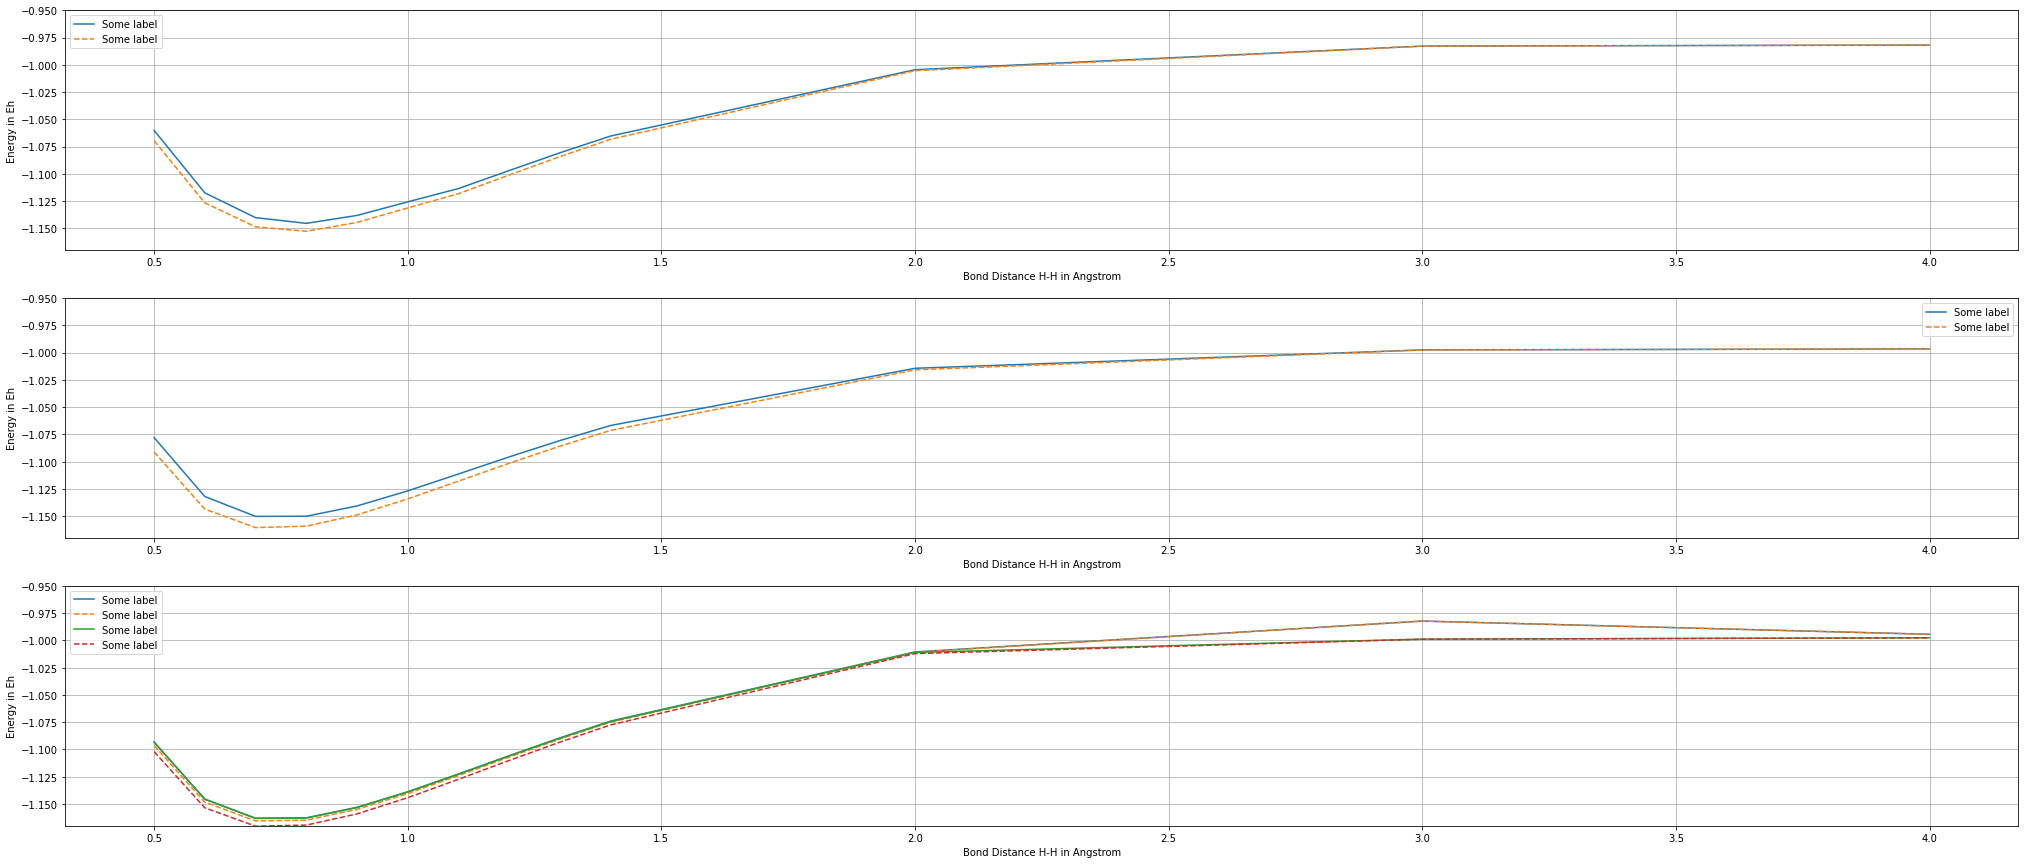

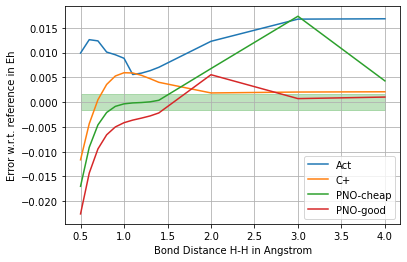

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(35,15))
ax[0].plot(distances, energy_active, label='Some label')
ax[0].plot(distances, energy_active+corr_active, '--', label='Some label')
ax[1].plot(distances, energy_cp, label='Some label')
ax[1].plot(distances, energy_cp+corr_cp, '--', label='Some label')
ax[2].plot(distances, energy_pno[0,:], label='Some label')
ax[2].plot(distances, energy_pno[0,:]+corr_pno[0,:], '--', label='Some label')
ax[2].plot(distances, energy_pno[1,:], label='Some label')
ax[2].plot(distances, energy_pno[1,:]+corr_pno[1,:], '--', label='Some label')
for i in range(3):
    ax[i].grid(True)
    ax[i].set_xlabel('Bond Distance H-H in Angstrom')
    ax[i].set_ylabel('Energy in Eh')
    ax[i].legend()
    ax[i].set_ylim((-1.17,-0.95))
plt.show()

fig2, ax2 = plt.subplots(nrows=1,ncols=3)
ax2[0].plot(distances, error)
ax2[1].plot(distances, err_act, distances, err_cp, distances, err_pno[0,:], distances, err_pno[1,:])
ax2[2].plot(distances, err_act, distances, err_cp, distances, err_pno[0,:], distances, err_pno[1,:])
ax2.grid(True)
ax2.set_xlabel('Bond Distance H-H in Angstrom')
ax2.set_ylabel('Error w.r.t. reference in Eh')
ax2.legend(['Act', 'C+', 'PNO-cheap', 'PNO-good'])
ax2.fill_between(distances, -1.6e-3, 1.6e-3, color='tab:green', alpha=.3)
fig2.show()


## References

to add: MA, the paper itself, PNO+MRA-PNO paper

[1] Valeev, E. F. Improving on the resolution of the identity in linear R12 ab initio theories. Chem. Phys. Lett. 395, 190–195 (2004).

[2] Torheyden, M. & Valeev, E. F. Universal perturbative explicitly correlated basis set incompleteness correction. J. Chem. Phys. 131, (2009).

[3] Kong, L. & Valeev, E. F. "SF-[2]_R12": A spin-adapted explicitly correlated method applicable to arbitrary electronic states. J. Chem. Phys. 135, (2011).

[4] Roskop, L. B., Kong, L., Valeev, E. F., Gordon, M. S. & Windus, T. L. Assessment of perturbative explicitly correlated methods for prototypes of multiconfiguration electronic structure. J. Chem. Theory Comput. 10, 90–101 (2014).

[5] McArdle, S. & Tew, D. P. Improving the accuracy of quantum computational chemistry using the transcorrelated method. 1–13 (2020).

[6] Motta, M. et al. Quantum simulation of electronic structure with a transcorrelated Hamiltonian: improved accuracy with a smaller footprint on the quantum computer. Phys. Chem. Chem. Phys. 12, 1–13 (2020).